# Analysing the Parties Press Release for 2019 Canadian Federal Election


**Packages Used:**

- Pandas
- NumPy
- Sklearn
- [NLTK](https://www.nltk.org/): a convenient Python library for natural language processing.
-------
This project has two goals: 
1. explore correlation and word visuzalition based on the press release.
2. predict the party based on the tone of the press release.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import re 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

## Naive Bayes classifier

Naive Bayes classifier is built with the Bayes Theorem Assumption


-- In the training set we calculate 
<center>
    \begin{align}
    \\ P(X \cap Y) = P(X| Y=y) P(Y)
    \end{align}
</center>


- And based on Bays we also have:

<center>
    \begin{align}
    \\ P(X \cap Y) = P(Y│X=x) P(X)
    \end{align}
</center>

Which is what we apply in the testing set to predict the category.

-------------------------------------
With that our model recipe has to make the following calculations:

**Training set**

1. Calculate the frequency of each party press release in the training df
2. Count how many times each word happens per party



**Testing set**
1. Calculate the # of words in a press release.
2. Using the intersection function calculate the P(Y|X=x)




In [2]:
df = pd.read_csv('canada_parties_pr.csv')
df.head()

,party,url,content,date
0,conservative,https://www.conservative.ca/the-hon-andrew-sch...,"\r\nFOR IMMEDIATE RELEASE\r\nOttawa, ON – The ...",2019-07-11
1,conservative,https://www.conservative.ca/justin-trudeau-mus...,"\r\nFOR IMMEDIATE RELEASE\r\n\r\nTORONTO, ON\r...",2019-07-11
2,conservative,https://www.conservative.ca/justin-trudeaus-ba...,"\r\nFOR IMMEDIATE RELEASE\r\nOTTAWA, ON – Pier...",2019-05-28
3,conservative,https://www.conservative.ca/conservatives-to-s...,\r\nNew conservative government to extend EI p...,2019-10-15
4,conservative,https://www.conservative.ca/andrew-scheer-reve...,\r\nConservatives unveil fully costed platform...,2019-10-11


In [3]:
df['party'].value_counts()

liberal         200
conservative    185
NDP             117
Name: party, dtype: int64

In [4]:
#define the stop words
stop_extra = ['*', '#', '?', '$', '!', '&',  '%', '\'','\'ll', '"','\'\'' '\'m', '\'re', '\'ve', '(', ')', '\'s', '-', '--']
stop = stopwords.words('english') + stop_extra

In [5]:
#function that tokenize a sentence and remove stop words
def sentence_to_word(df, column_name, stop):
    
    #lower case
    df[column_name] = df[column_name].apply(lambda string: string.lower())
    df['words'] = df[column_name].apply(nltk.word_tokenize)
    df['words'] = df['words'].apply(lambda x: [item for item in x if item not in stop])
    df['words'] = df['words'].apply(lambda x: [item for item in x if item.isalpha()])
    
    return df

In [6]:
#enconde the labels
le = LabelEncoder()
enc = OneHotEncoder()
df['labels']=le.fit_transform(df[['party']])

**The Labels are**

In [7]:
df[['labels', 'party']].drop_duplicates(keep='last')

,labels,party
184,1,conservative
384,2,liberal
501,0,NDP


In [8]:
#separate test and training
y = df['labels']
X = df['content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f'test size: '{len(X_test)}' and training size: ')

In [9]:
#tokenize the press release and lower case and remove stop words
training_set = pd.DataFrame(data = {'party': y_train, "content":X_train})
training_set = sentence_to_word(training_set, 'content', stop)
training_set.head()

,party,content,words
423,0,\r\nfamilies can’t go four more years without ...,"[families, go, four, years, without, drug, den..."
19,1,\r\ntoday justin trudeau announced measures\r\...,"[today, justin, trudeau, announced, measures, ..."
323,2,"\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nottawa, o...","[share, ottawa, ontario, response, andrew, sch..."
333,2,"\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\ntoronto, ...","[share, toronto, following, statement, hon, ma..."
56,1,"\r\nfor immediate release\r\n\r\ntoronto, on –...","[immediate, release, toronto, honourable, andr..."


In [10]:
#counts the frequency
rows = list()
for row in training_set[['party', 'words']].iterrows():
    r = row[1]
    #print(r)
    for word in r.words:
        rows.append((r.party, word))
single_words = pd.DataFrame(rows, columns=['party', 'word'])
single_words['counter'] = 1



#count total words of party
single_words['n_parties']= single_words.groupby('party')['counter'].transform('sum')

#count the frequency of words
counts = single_words.groupby('word')\
    .agg({'counter':'sum'})\
    .rename(columns={'counter':'n_w'})
counts = counts.reset_index(level=['word'])

#counts the frequency of words by party
counts2 = single_words.groupby(['word', 'party'])\
    .agg({'counter':'sum'})\
    .rename(columns={'counter':'n_wp'})
counts2 = counts2.reset_index()

-> next steps 
the current code is not calculating the probability of not being in that category
I need to find a way to add the missing category in training set using the Laplace smoother. A good example is the word yazidis that has only one records when it should have had 3. 

The next step is make this into a function so I can apply into the news.

In [13]:
def vector_to_list (df, label_key, words='words'):
    '''creates a df of single label and words and count # of words per them'''
    #counts the frequency
    rows = list()

    for row in df[[label_key, words]].iterrows():
        r = row[1]
        #print(r)
        for word in r.words:
            
            rows.append((r[0], word))
    new_df = pd.DataFrame(rows, columns=[label_key, 'word'])
    new_df['counter'] = 1
    
    #count total words of party
    new_df['n_parties']= new_df.groupby([label_key])['counter'].transform('sum')
    new_df.sort_values(by=['word', label_key] , ascending = [True, True], inplace =True)

    return new_df

#break words from parties returning unique values for both
def label_and_words_unique(single_words, label_key, word_key= 'word'):
    label_df = single_words[[label_key]].drop_duplicates(keep= 'last').sort_values(by=[label_key] , ascending = [True])
    
    words_df = single_words[[word_key]].drop_duplicates(keep= 'last').sort_values(by=[word_key] , ascending = [True])
    return {'label_df': label_df, 'words_df':words_df}

def cartesian_product(label_df, word_df, label_key):
    '''
    data input needs to be only the values without column name, use [] to remove the label
    '''
    #index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    index = pd.MultiIndex.from_product([label_df, word_df], names=[label_key, 'word'])
    return pd.DataFrame(index=index).reset_index()

def counts_words(dataframe, cols, colname):
    #count the frequency of words
#     cols =np.where(label_key ==None, word_key, [word_key, label_key])
#     print(cols)
    counts = dataframe.groupby(cols)\
    .agg({'counter':'sum'})\
    .rename(columns={'counter': colname})
    counts = counts.reset_index()
    return counts




def one_contigence_table(df, content_key, label_key, stop):
    ''' 
    df needs to be in the content/label format, 
    content and label is the name of the variables within the df
    stop is the stop words that we need to remove from the the content
    '''
    #vectorize the words and we remove the stop words and lower case 
    df = sentence_to_word(df, content_key, stop)
    
    #make the vector words into rows of the dataframe
    single_words = vector_to_list (df, label_key)
    
    #create a unique word/ label df
    uniques = label_and_words_unique(single_words, label_key)
    
    #catersian product between two dfs
    ct = cartesian_product(uniques['label_df'][uniques['label_df'].columns[0]], uniques['words_df'][uniques['words_df'].columns[0]], label_key)
    

      
    #counts words per party
    nw = 'n_w'
    nwp = 'nwp'
    cols = ['word', label_key] 
    counts = counts_words(single_words, cols, nwp)
    #counts words
    counts2 = counts_words(single_words, 'word', nw)
    
    label_counts = single_words[[label_key, 'n_parties']].drop_duplicates(keep = 'last')
    
    #now 
    
    
    contigence_table = pd.merge(ct, counts, on=['word', label_key], how = 'left')
    contigence_table = pd.merge(contigence_table, label_counts, on=[label_key], how = 'inner')
    contigence_table['n'] =len(single_words['word']) #all words

    contigence_table = pd.merge(contigence_table, counts2, on=['word'], how= 'left')
    n_uniques = contigence_table['word'].nunique()
    contigence_table = contigence_table.fillna(0)
    contigence_table['unique_words'] = n_uniques
    contigence_table['prob_y'] = contigence_table['n_parties']/contigence_table['n']

    contigence_table['prob_xgy'] = (1 + contigence_table['n_w'])/(contigence_table['unique_words']+contigence_table['n_parties']) #+1 forlaplace smoother

    
    return contigence_table

In [23]:

contigence_table = one_contigence_table(training_set,'content', 'party', stop)

contigence_table[contigence_table['word']=='indigenous'].head()
#contigence_table.head()

,party,word,nwp,n_parties,n,n_w,unique_words,prob_y,prob_xgy
3489,0,indigenous,32.0,14427,66519,67,7679,0.216885,0.003076
11168,1,indigenous,18.0,25291,66519,67,7679,0.380207,0.002062
18847,2,indigenous,17.0,26801,66519,67,7679,0.402907,0.001972


## Testing set
Now that we have the probabilities calculated, we can try to predict the party or the political view given the words used.


In [15]:
test_df = pd.DataFrame(data={'content': X_test, 'party_real': y_test})


In [16]:
test_df = sentence_to_word(test_df, 'content', stop)


#make the vector words into rows of the dataframe
test_single_words = vector_to_list (test_df, 'party_real')

#create a unique word/ label df
test_uniques = label_and_words_unique(test_single_words, 'party_real')

#catersian product between two dfs
ct = cartesian_product(test_uniques['label_df'][test_uniques['label_df'].columns[0]], 
                       test_uniques['words_df'][test_uniques['words_df'].columns[0]], 'party')

rows = list()
for row in test_df[['content','party_real','words']].iterrows():
    r = row[1]
    #print(r)
    for word in r.words:
        rows.append((r.content, r.party_real, word))

test_df = pd.DataFrame(rows, columns=['content','party_real', 'word'])
test_df = pd.merge(ct, test_df, on = 'word', how = 'left')
test_df = test_df.sort_values(by=['content','word', 'party'] , ascending = [True, False, True])

#test_df[test_df['word']=='wall']
test_df.head()



,party,word,content,party_real
16328,0,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1
32794,1,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1
49260,2,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1
16243,0,world,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1
16244,0,world,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1


In [17]:

#applies the Laplace smoother for the words that are not present in the training dataset
test_df = pd.merge(test_df, contigence_table,  on=['word', 'party'], how='left')
test_df.rename(columns  = {"party": "party_pred"},inplace = True) 

test_df.head()

,party_pred,word,content,party_real,nwp,n_parties,n,n_w,unique_words,prob_y,prob_xgy
0,0,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,0.0,14427.0,66519.0,1.0,7679.0,0.216885,0.000090
1,1,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,1.0,25291.0,66519.0,1.0,7679.0,0.380207,0.000061
2,2,yazidis,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,0.0,26801.0,66519.0,1.0,7679.0,0.402907,0.000058
3,0,world,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,14.0,14427.0,66519.0,146.0,7679.0,0.216885,0.006650
4,0,world,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,14.0,14427.0,66519.0,146.0,7679.0,0.216885,0.006650


In [ ]:

#fill nas
test_df['n_w'] = test_df['n_w'].fillna(1)
test_df['nwp'] = test_df['nwp'].fillna(0)
test_df['n'] = test_df['n'].fillna(contigence_table['n'][0])
test_df['unique_words'] = test_df['unique_words'].fillna(contigence_table['n'][0])
test_df.loc[test_df['party_pred']==0, 'n_parties'] = contigence_table[contigence_table['party']==0]['n_parties'].values[0]
test_df.loc[test_df['party_pred']==1, 'n_parties'] = contigence_table[contigence_table['party']==1]['n_parties'].values[0]
test_df.loc[test_df['party_pred']==2, 'n_parties'] = contigence_table[contigence_table['party']==2]['n_parties'].values[0]

test_df.loc[test_df['party_pred']==0, 'prob_y'] = contigence_table[contigence_table['party']==0]['prob_y'].values[0]
test_df.loc[test_df['party_pred']==1, 'prob_y'] = contigence_table[contigence_table['party']==1]['prob_y'].values[0]
test_df.loc[test_df['party_pred']==2, 'prob_y'] = contigence_table[contigence_table['party']==2]['prob_y'].values[0]

test_df['prob_xgy'] = test_df['prob_xgy'].fillna(1/(test_df['unique_words']+test_df['n_parties']))

test_df = pd.merge

In [542]:
#test_df[test_df['content']==test_df['content'].iloc[533]]
#group by prod
test_prediction = test_df.groupby(['content', 'party_pred', 'party_real', 'prob_y']).agg({'prob_xgy': 'prod'})
test_prediction = test_prediction.reset_index()
test_prediction['prob_party'] = test_prediction['prob_xgy']*test_prediction['prob_y']


test_prediction = test_prediction.loc[test_prediction.groupby(['content', 'party_pred']).prob_party.agg('idxmax')]

test_prediction.head()

,content,party_pred,party_real,prob_y,prob_xgy,prob_party
0,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",0,1,0.216885,0.0,0.0
1,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,1,0.380207,0.0,0.0
2,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",2,1,0.402907,0.0,0.0
3,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nbrockvill...,0,2,0.216885,0.0,0.0
4,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nbrockvill...,1,2,0.380207,0.0,0.0


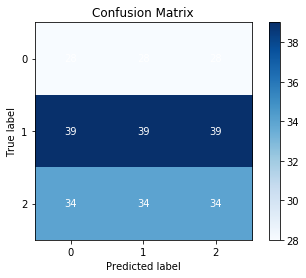

In [543]:
skplt.metrics.plot_confusion_matrix(test_prediction['party_real'], test['party_pred']);


#test

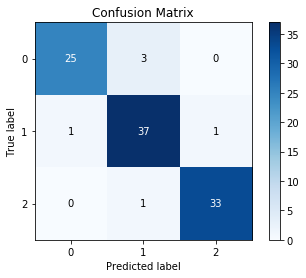

In [544]:
#vectorized the words in the keyword
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)
ndf = pd.SparseDataFrame(
    X_train_vectorized.toarray(), columns=vect.get_feature_names()
)

#apply pre made model
clfrNB = MultinomialNB(alpha=0.1)
clfrNB.fit(X_train_vectorized, y_train)
y_pred = clfrNB.predict(vect.transform(X_test))
skplt.metrics.plot_confusion_matrix(y_test, y_pred);


_Notebook by: Andresa de Andrade inspired by the work of François Maillet in the 2015 Federal election analysis._
